## Librerias

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


## Carga de datos

In [38]:
# Directorios base
train_dir = "../data/raw/train"
test_dir = "../data/raw/test"

# Dataset de entrenamiento (80%) y validación (20%)
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Dataset de prueba
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=32
)

class_names = train_ds.class_names
print("Clases detectadas:", class_names)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Clases detectadas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalización y Data Augmentation

In [39]:
# Reinicia el kernel si ya habías mapeado antes
# (Ctrl+Shift+P → Restart Kernel)

# Augmentación ligera (solo cambios realistas)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.05)
])

# Normalización a rango [0,1]
normalization_layer = layers.Rescaling(1./255)

# Aplicar en orden correcto
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


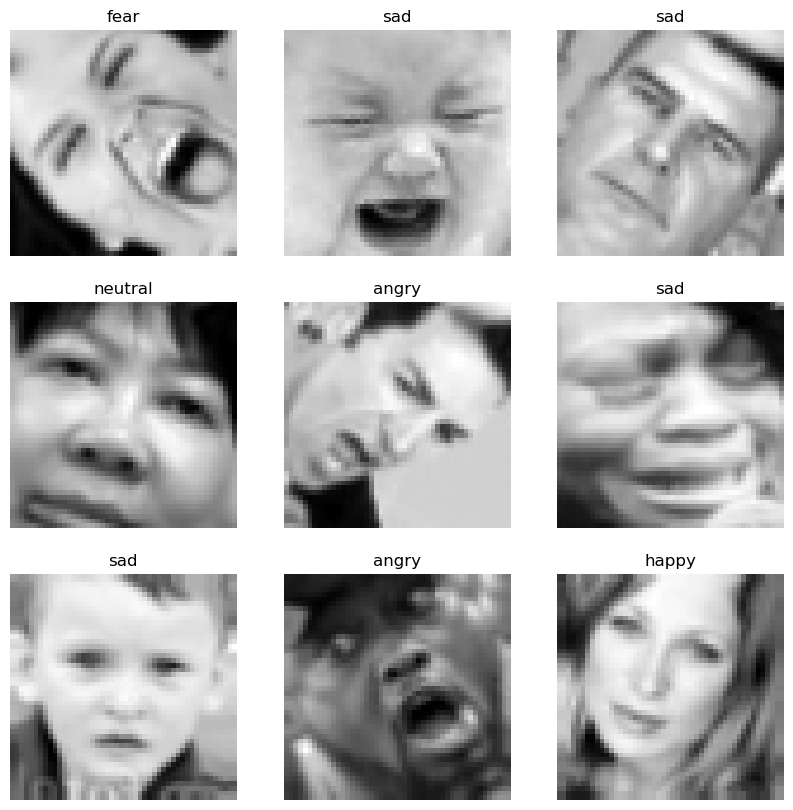

In [40]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()


## Definición del modelo CNN

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()


c:\Users\juanf\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

## Compilación del modelo

In [42]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Entrenamiento con Early Stopping

In [45]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[callback]
)


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5228 - loss: 1.2552 - val_accuracy: 0.5492 - val_loss: 1.1901
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5225 - loss: 1.2519 - val_accuracy: 0.5426 - val_loss: 1.2226
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5276 - loss: 1.2452 - val_accuracy: 0.5473 - val_loss: 1.1929
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5289 - loss: 1.2447 - val_accuracy: 0.5518 - val_loss: 1.1938
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5303 - loss: 1.2363 - val_accuracy: 0.5537 - val_loss: 1.1841
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.5304 - loss: 1.2370 - val_accuracy: 0.5543 - val_loss: 1.1898
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5323 - loss: 1.2376 - val_accuracy: 0.5553 - val_loss: 1.1841
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.5373 - loss: 1.2257 - 

## Visualización de resultados

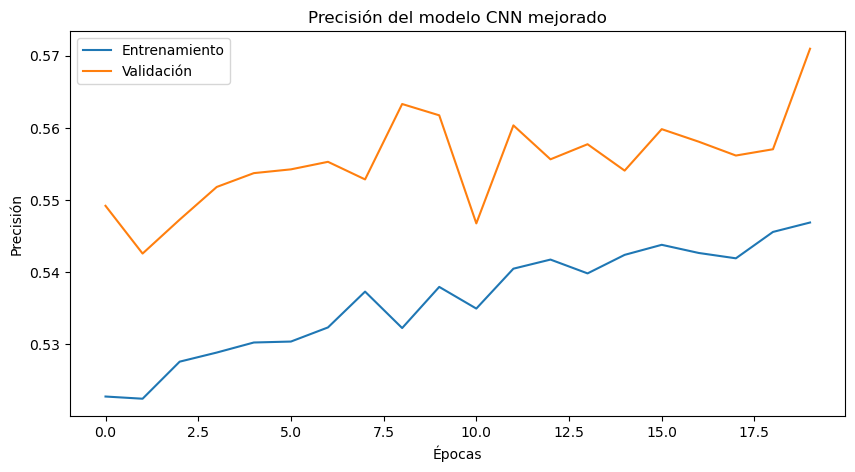

In [46]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión del modelo CNN mejorado")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.show()

## Modelo mejorado: Transfer Learning con MobileNetV2


In [57]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Cargar MobileNetV2 preentrenada (sin las capas finales de clasificación)
base_model = MobileNetV2(
    input_shape=(48, 48, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar las capas base (no se reentrenan)
base_model.trainable = False

base_model.summary()


C:\Users\juanf\AppData\Local\Temp\ipykernel_424\2909681514.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 24, 24,    │        864 │ input_layer_18[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 24, 24,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 24, 24,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 24, 24,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 24, 24,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 24, 24,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 25, 25,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 12, 12,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 12, 12,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 12, 12,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Preparar los datasets para MobileNetV2

In [58]:
train_ds_rgb = image_dataset_from_directory(
    "../data/raw/train",
    image_size=(48, 48),
    color_mode="rgb",
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds_rgb = image_dataset_from_directory(
    "../data/raw/train",
    image_size=(48, 48),
    color_mode="rgb",
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

test_ds_rgb = image_dataset_from_directory(
    "../data/raw/test",
    image_size=(48, 48),
    color_mode="rgb",
    batch_size=32
)

class_names = train_ds_rgb.class_names
print("Clases detectadas:", class_names)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Clases detectadas: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Normalización y optimización

In [59]:
normalization_layer = layers.Rescaling(1./255)

train_ds_rgb = train_ds_rgb.map(lambda x, y: (normalization_layer(x), y))
val_ds_rgb = val_ds_rgb.map(lambda x, y: (normalization_layer(x), y))
test_ds_rgb = test_ds_rgb.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds_rgb = train_ds_rgb.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_rgb = val_ds_rgb.cache().prefetch(buffer_size=AUTOTUNE)


### Definición del modelo con MobileNetV2
Se añade una capa de *Global Average Pooling* seguida de una capa *Dense* intermedia y una capa de salida con activación `softmax` para clasificar las emociones.


In [60]:
model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

model_tl.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Compilación y entrenamiento con EarlyStopping

In [63]:
from tensorflow.keras.callbacks import EarlyStopping

model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='mejor_modelo_mobile.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_tl = model_tl.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=40,
    callbacks=[callback]
)


Epoch 1/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.5015 - loss: 1.2925 - val_accuracy: 0.4076 - val_loss: 1.5915
Epoch 2/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5152 - loss: 1.2542 - val_accuracy: 0.3947 - val_loss: 1.6003
Epoch 3/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.5272 - loss: 1.2151 - val_accuracy: 0.4074 - val_loss: 1.6062
Epoch 4/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.5416 - loss: 1.1778 - val_accuracy: 0.4052 - val_loss: 1.6283
Epoch 5/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.5525 - loss: 1.1519 - val_accuracy: 0.4048 - val_loss: 1.6745
Epoch 6/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.5645 - loss: 1.1184 - val_accuracy: 0.4015 - val_loss: 1.6886
Epoch 7/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - accuracy: 0.5751 - loss: 1.0887 - val_accuracy: 0.3977 - val_loss: 1.6905
Epoch 8/40
718/718 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.5871 - loss: 1.0603 - 

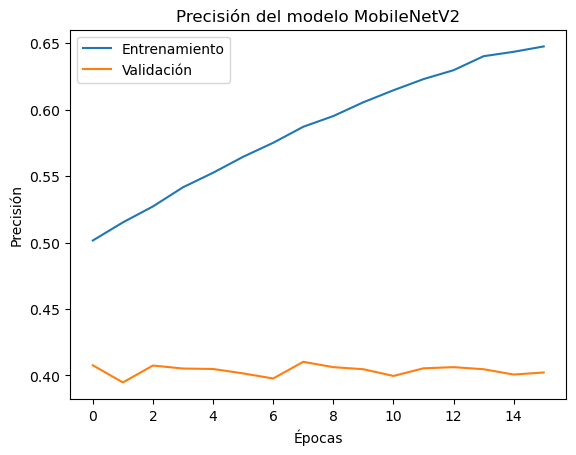

In [64]:
plt.plot(history_tl.history['accuracy'])
plt.plot(history_tl.history['val_accuracy'])
plt.title('Precisión del modelo MobileNetV2')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()


## Fine-Tuning controlado del modelo MobileNetV2

In [66]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Cargar el modelo base preentrenado sin la parte superior
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar las capas base (no se actualizan durante el entrenamiento inicial)
base_model.trainable = False

# Construcción del modelo nuevo
model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  #
])

# Compilar el modelo
model_tl.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento inicial con EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Redimensionar las imágenes a 224x224 para MobileNetV2
resize_layer = tf.keras.layers.Resizing(224, 224)

train_ds_rgb = train_ds_rgb.map(lambda x, y: (resize_layer(x), y))
val_ds_rgb = val_ds_rgb.map(lambda x, y: (resize_layer(x), y))
test_ds_rgb = test_ds_rgb.map(lambda x, y: (resize_layer(x), y))


history_tl = model_tl.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,     
    epochs=20,
    callbacks=[callback]
)


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 353s 487ms/step - accuracy: 0.3670 - loss: 1.6244 - val_accuracy: 0.4478 - val_loss: 1.4615
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 322s 448ms/step - accuracy: 0.4245 - loss: 1.4951 - val_accuracy: 0.4759 - val_loss: 1.3920
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 313s 436ms/step - accuracy: 0.4469 - loss: 1.4438 - val_accuracy: 0.4825 - val_loss: 1.3833
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 313s 436ms/step - accuracy: 0.4553 - loss: 1.4207 - val_accuracy: 0.4980 - val_loss: 1.3359
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 2294s 3s/step - accuracy: 0.4648 - loss: 1.3974 - val_accuracy: 0.4943 - val_loss: 1.3205
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 318s 443ms/step - accuracy: 0.4733 - loss: 1.3689 - val_accuracy: 0.4929 - val_loss: 1.3276
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 318s 442ms/step - accuracy: 0.4839 - loss: 1.3529 - val_accuracy: 0.4954 - val_loss: 1.3254
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 318s 443ms/step - accuracy: 0.4872 - l

In [71]:
# Guardar el modelo completo (estructura + pesos + compilación)
model_tl.save("modelo_mobilenetv2_final.h5")

print("Modelo guardado exitosamente como 'modelo_mobilenetv2_final.h5'")

model_tl.save("modelo_mobilenetv2_final.keras")
print("Modelo guardado también en formato moderno .keras")



Modelo guardado exitosamente como 'modelo_mobilenetv2_final.h5'
Modelo guardado también en formato moderno .keras


## Fine-Tuning controlado del modelo MobileNetV2

Hasta ahora el modelo MobileNetV2 se entrenó con la base congelada, lo cual permitió
ajustar únicamente las capas densas finales.  
A continuación, se realiza un *fine-tuning* controlado, descongelando las últimas capas
de la MobileNetV2 para refinar el aprendizaje sobre el dataset de emociones.


In [72]:
# Descongelar las últimas capas de la MobileNetV2
base_model.trainable = True

# Solo entrenar las últimas 50 capas para evitar sobreajuste
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compilar con un learning rate muy bajo para no destruir los pesos preentrenados
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento fino (Fine-Tuning)
history_finetune = model_tl.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=10,
    callbacks=[callback]
)


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 530s 726ms/step - accuracy: 0.3843 - loss: 1.6286 - val_accuracy: 0.4928 - val_loss: 1.4466
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 514s 716ms/step - accuracy: 0.4704 - loss: 1.3800 - val_accuracy: 0.4999 - val_loss: 1.3743
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 505s 704ms/step - accuracy: 0.5175 - loss: 1.2521 - val_accuracy: 0.5267 - val_loss: 1.3034
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 508s 708ms/step - accuracy: 0.5526 - loss: 1.1502 - val_accuracy: 0.5292 - val_loss: 1.2775
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 512s 714ms/step - accuracy: 0.5824 - loss: 1.0661 - val_accuracy: 0.5374 - val_loss: 1.2597
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 507s 706ms/step - accuracy: 0.6085 - loss: 0.9852 - val_accuracy: 0.5461 - val_loss: 1.2473
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 493s 687ms/step - accuracy: 0.6352 - loss: 0.9142 - val_accuracy: 0.5513 - val_loss: 1.2475
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 506s 705ms/step - accuracy: 0.6634 -

In [ ]:
model_tl.save("modelo_mobilenetv2_finetuned.keras")
print("Modelo guardado en formato moderno .keras")



Modelo guardado también en formato moderno .keras


## Evaluar desempeño del modelo en test

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear test_generator 
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "../data/raw/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  
    shuffle=False
)



# Evaluar el modelo ya entrenado
test_loss, test_acc = model_tl.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Found 7178 images belonging to 7 classes.
 59/225 ━━━━━━━━━━━━━━━━━━━━ 1:06 402ms/step - accuracy: 0.1075 - loss: 2.1911